## **Importing Libraries**

A library was built with the name tfqml.py to store all the dependencies, classes and methods that are used in this work, these classes are
- ClassicalPreprocessing,
- QuantumPreprocessing,
- CircuitLayer,
- QuantumModel-

together with the methods 
- visualization and 
- save_data


the dependencies are:
- numpy 
- pandas 
- matplotlib
- sklearn
- cirq
- tensorflow_quantum
- tensorflow
- sympy

In [1]:
from tfqml import *

2022-02-25 10:23:08.856436: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 10:23:08.856455: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-25 10:23:09.855759: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-25 10:23:09.855780: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (toto): /proc/driver/nvidia/version does not exist
2022-02-25 10:23:09.856018: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To en

## **Choose the 8 stocks**

we select 8 stocks from 8 conglomerates based on the dataset of Xu et al. [[2]](https://aclanthology.org/P18-1183/): 

- Basic Materials: TOTAL S.A. "TOT"

- Consumer Goods: Appel Inc. "AAPL"

- Healthcare: AbbVie Inc. "ABBV"

- Services: Wall-Mart Stores Inc. "WMT"

- Utilites: Duke energy corporation "DUK"

- Financial: HSBS Holding pcl "HSBC"

- Industrial Goods: ABB Ltd. "ABB"

- Technology: China Mobile Limited "CHL"

In [2]:
name_stocks = ['AAPL','ABB','ABBV','TOT','WMT','DUK','CHL','HSBC']

# Classical Preprocessing

The methods of our library are used to preprocess the csv files of the 8 stocks,
We consider 30 days por each instance and we obtain the shape of the train and test dataset

In [3]:
cp = ClassicalPreprocessing(filename=name_stocks[0])
days = 30
x_train,y_train,x_test,y_test = cp.preprocessing(days=days,flag_pca=True)

Shape of train data: (880, 1)
Shape of test data: (378, 1)


At this point we can check the dataset for trai nand test and confirm is the same dimention of the days and using a normalization

In [4]:
x_train[0]

array([0.50210573, 0.5198373 , 0.5154993 , 0.52431991, 0.52865792,
       0.50093085, 0.50407582, 0.52309078, 0.54584719, 0.56281965,
       0.56377762, 0.56446444, 0.56247619, 0.56835058, 0.54024395,
       0.54277451, 0.50749205, 0.49944871, 0.52558515, 0.51186616,
       0.49496611, 0.50047898, 0.51202891, 0.5010935 , 0.46798009,
       0.45310439, 0.45507448, 0.46729319, 0.43667413, 0.44171711])

# Quantum Pre processing

Convert the classical information fo the train and test dataset into a quantumcircuit this is possible using cirq, for this proposal we consider two encoding method, amplitude and angle, we keep the last one, for its result it was very well with respect the amplitude. Using as reference this the paper [Quantum Long Short-Term Memory](https://arxiv.org/pdf/2009.01783.pdf)  for the encoding, is important apply the arctang of the data and add a proposal. It was proposed for this encoding to reduce the number of qubits with the consideration that there are 30 data, one for each of the 3 coordinates, therefore the number of days divided by 3 will have to be used, it should be noted that data of multiples of 3 are needed to use this encoding.

In [5]:
qp = QuantumPreprocessing(x_train,x_test)
x_trainq,x_testq = qp.data2qubits()

Print a quantum circuit of our encoding, apart of the angle we add a Hadamard prevous the X and Z rotation and  do an entenglament for each pair of qubits. You can see in the next cell

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


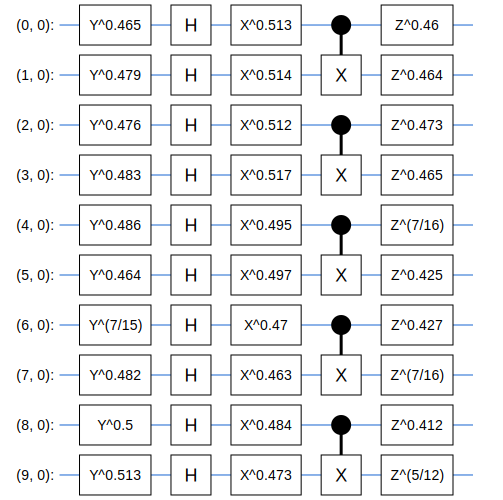

In [6]:
qp.print_circuit(0)

following with the idea that they must be multiples of 3, the ansatz is used and this is designed with a layer of RY followed by CX with the qubit target of each CX applying an RY and then an H and the same is done with the RX gate, the number of parameters for each layer is indicated. these are 15 per layer. We use reference the tutorial from [tensorflow Quantum](https://www.tensorflow.org/quantum/tutorials/mnist)

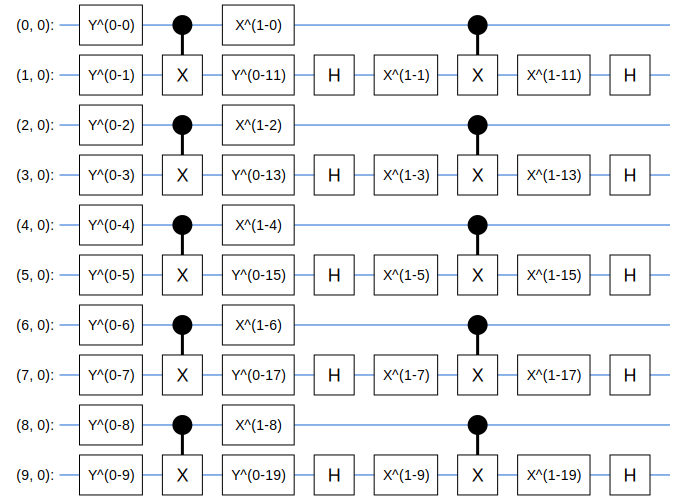

In [7]:
qubits_required = days//3
qm = QuantumModel(qubits_required)
model_circuit, model_readout =qm.quantum_circuit([cirq.Y,cirq.X])
SVGCircuit(model_circuit)

Creating our LSTM hibryd model.The first layer is our proposal which input is 30 parameters per instance and output is 10, followed by LSTM and Dropout layers, at the end a Dense layer to have an output value.


We use a noise Parameter Quantum circuit , this is posible use the NoisyPQC method, and is important add repetitions  for the time is 10 and consider a the fag dample_based= True, this las one parameter is improtant to run our noise simulation. More information you can find [here](https://www.tensorflow.org/quantum/api_docs/python/tfq/layers/NoisyPQC)


In [8]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The NoisyPQC layer returns the expected value of the readout gate.
    tfq.layers.NoisyPQC(model_circuit, model_readout,repetitions=10,sample_based=True),
    tf.keras.layers.Reshape((1,10)),
    tf.keras.layers.LSTM(units=100, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=100, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=5),
    tf.keras.layers.Dense(units=1),
])


Apply the as loss the MSE and optimizer ADAM

In [9]:
model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noisy_pqc (NoisyPQC)        (None, 10)                30        
                                                                 
 reshape (Reshape)           (None, 1, 10)             0         
                                                                 
 lstm (LSTM)                 (None, 1, 100)            44400     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 5)                 2

Consider only 60 epoch with a batch size of 32

In [10]:
qnn_history = model.fit(
      x_trainq, y_train,
      batch_size=32,
      epochs=60)

qnn_results = model.evaluate(x_testq, y_test)


Epoch 1/60
27/27 [==============================] - 33s 1s/step - loss: 0.2493 - root_mean_squared_error: 0.4993
Epoch 2/60
27/27 [==============================] - 27s 1s/step - loss: 0.0637 - root_mean_squared_error: 0.2523
Epoch 3/60
27/27 [==============================] - 27s 1s/step - loss: 0.0213 - root_mean_squared_error: 0.1461
Epoch 4/60
27/27 [==============================] - 28s 1s/step - loss: 0.0166 - root_mean_squared_error: 0.1289
Epoch 5/60
27/27 [==============================] - 28s 1s/step - loss: 0.0139 - root_mean_squared_error: 0.1181
Epoch 6/60
27/27 [==============================] - 27s 992ms/step - loss: 0.0137 - root_mean_squared_error: 0.1170
Epoch 7/60
27/27 [==============================] - 27s 1s/step - loss: 0.0117 - root_mean_squared_error: 0.1082
Epoch 8/60
27/27 [==============================] - 27s 994ms/step - loss: 0.0113 - root_mean_squared_error: 0.1063
Epoch 9/60
27/27 [==============================] - 28s 1s/step - loss: 0.0107 - root_mean

Plot the result between the  real and predict with both data set, train and test.

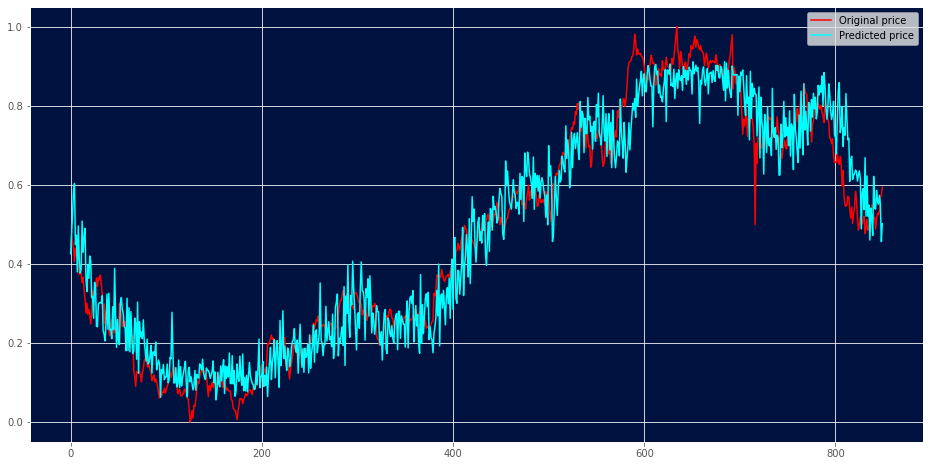

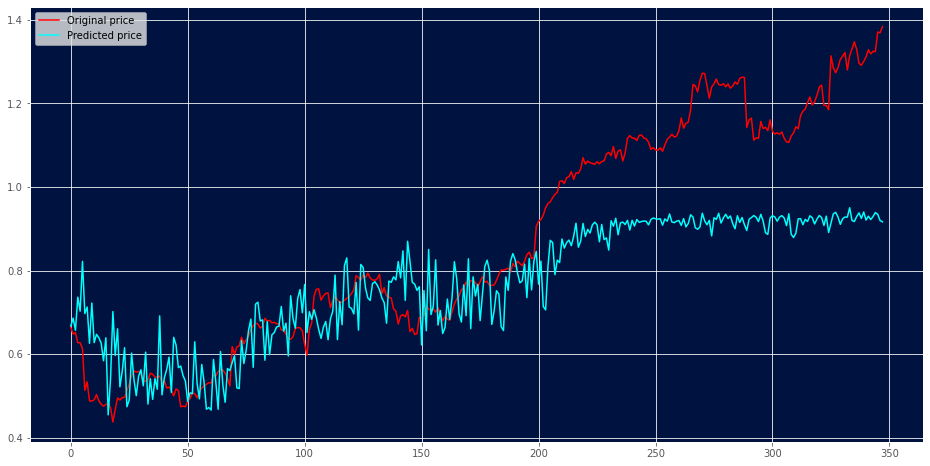

In [11]:
visualization(model,x_trainq,y_train)
visualization(model,x_testq,y_test)

Finally, we save the model and outputs, the proposal save this model.

In [12]:
save_data(model,x_trainq,y_train,name_stocks[1]+"_train")
save_data(model,x_testq,y_test,name_stocks[1]+"_test")

MAE 5.64%
MAE 14.22%
